## Processing the results after retraining and test of RO and ERO networks

In [1]:
"""
=================== Import required libraries ===================
"""

import csv
import ast
import os
import yaml
import pickle
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap


from pathlib import Path



In [2]:
PicklesDataBank_folder = r'D:\Thesis2024\Dissertation\PickleFiles'
output_folder = r'D:\Thesis2024\Dissertation\Hydrographs'

pickle_file_path = os.path.join(PicklesDataBank_folder, 'data_package_obs' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    Obs = pickle.load(f)

pickle_file_path = os.path.join(PicklesDataBank_folder, 'ERO_sims_seeds' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    ERO = pickle.load(f)

pickle_file_path = os.path.join(PicklesDataBank_folder, 'Top_10_Configs_94_sims_seeds_percentiles' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    Top_10 = pickle.load(f)

pickle_file_path = os.path.join(PicklesDataBank_folder, 'Catchment_Wise_Configs_230_sims_seeds_percentiles' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    CWC = pickle.load(f)

pickle_file_path = os.path.join(PicklesDataBank_folder, 'K_means_Configs_80_sims_seeds_percentiles' + '.p')
# Load the data package from the pickle file
with open(pickle_file_path, 'rb') as f:
    K_means = pickle.load(f)


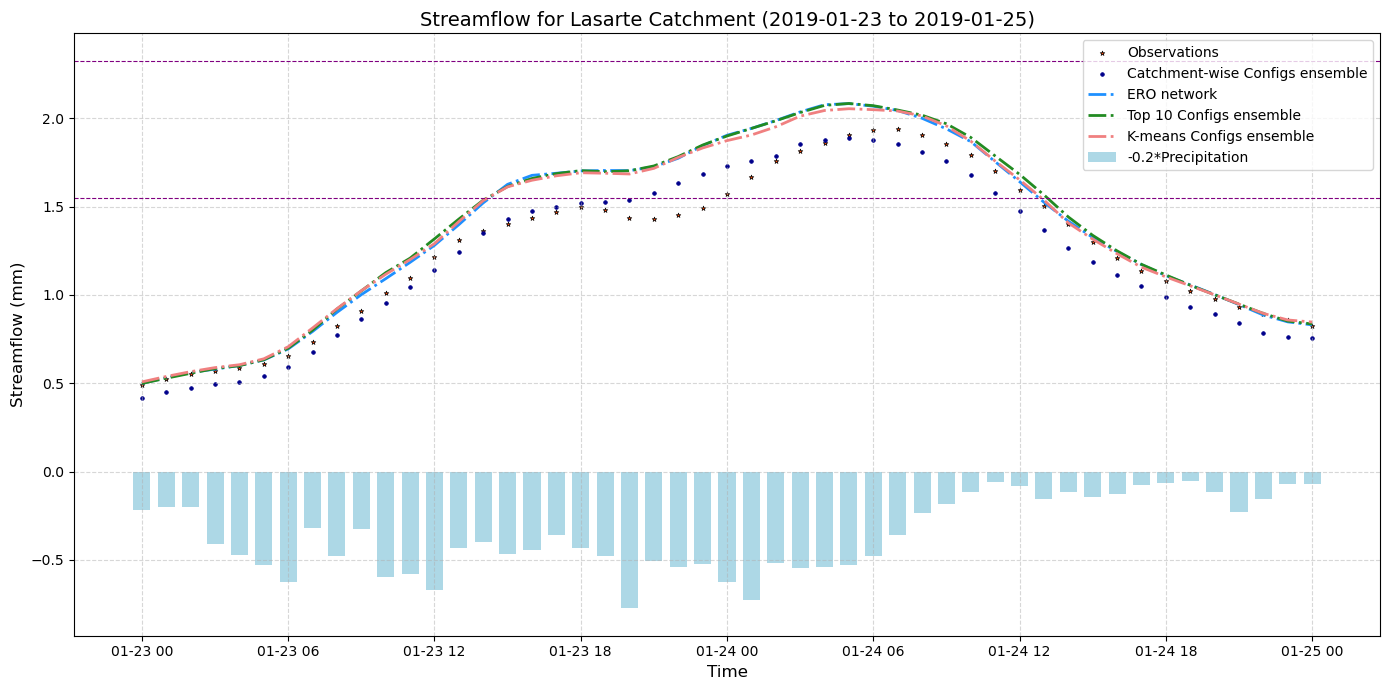

In [12]:

def plot_simulations(start_date_hr, end_date_hr, basin, seeds):

    # Load observation timestamp data (hourly)
    obs_hourly_timestamp = Obs[basin]['obs_hourly_timestamp']['timestamp']

    # Select a subset of the timestamp array within the specified date range
    mask = (obs_hourly_timestamp >= start_date_hr) & (obs_hourly_timestamp <= end_date_hr)
    timestamp_subset_hourly = obs_hourly_timestamp[mask].values

    # Convert timestamp_subset_hourly to a Pandas Series for indexing consistency
    timestamp_subset_hourly = pd.Series(timestamp_subset_hourly)

    # Load hourly observation data
    obs_hourly = Obs[basin]['qobs_mean_hr']

    # Load hourly precipitation data
    prec_hourly = Obs[basin]['prec_hourly']

    # Initialize empty lists to store the predictions for each variable
    ERO_hourly_values = []
    CWC_hourly_values = []
    Top_10_hourly_values = []
    K_means_hourly_values = []

    # Loop through each seed and append predictions
    for seed in seeds:
        ERO_hourly_values.append(ERO[seed]['1H'][basin]['qsim'])
        CWC_hourly_values.append(CWC[seed]['1H'][basin]['qsim']['5% percentile'])
        Top_10_hourly_values.append(Top_10[seed]['1H'][basin]['qsim']['50% percentile'])
        K_means_hourly_values.append(K_means[seed]['1H'][basin]['qsim']['50% percentile'])

    # Convert the lists of predictions into NumPy arrays (2D: seeds x time steps)
    ERO_hourly_array = np.array(ERO_hourly_values)
    CWC_hourly_array = np.array(CWC_hourly_values)
    Top_10_hourly_array = np.array(Top_10_hourly_values)
    K_means_hourly_array = np.array(K_means_hourly_values)

    # Calculate the median across all seeds (axis=0: median for each time step)
    ERO_hourly_med = np.median(ERO_hourly_array, axis=0)[mask]
    CWC_hourly_med = np.median(CWC_hourly_array, axis=0)[mask]
    Top_10_hourly_med = np.median(Top_10_hourly_array, axis=0)[mask]
    K_means_hourly_med = np.median(K_means_hourly_array, axis=0)[mask]

    # Mask the data using the index alignment from the timestamp
    obs_hourly_subset = obs_hourly.loc[mask]
    prec_hourly_subset = prec_hourly.loc[mask]

    # Create the plot
    plt.figure(figsize=(14, 7))

    # Define color scheme
    colors = {
        'ERO': 'dodgerblue',
        'CWC': 'darkblue',
        'Top_10': 'forestgreen',
        'K_means': 'lightcoral',
        'precip': 'lightblue',
        'observations': 'orangered'
    }

    # Define line styles and plot styles
    line_styles = {
        'observations': {'color': colors['observations'], 'marker': '*', 's': 12, 'edgecolor': 'black', 'linewidths': 0.5},
        'ERO': {'color': colors['ERO'], 'linestyle': '-.', 'linewidth': 2},
        'CWC': {'color': colors['CWC'], 'marker': 'o', 's': 7, 'linewidth': 0.5},
        'Top_10': {'color': colors['Top_10'], 'linestyle': '-.', 'linewidth': 2},
        'K_means': {'color': colors['K_means'], 'linestyle': '-.', 'linewidth': 2},
    }

    # Plot observations
    plt.scatter(timestamp_subset_hourly, obs_hourly_subset.values.flatten(), **line_styles['observations'], label='Observations')
    plt.scatter(timestamp_subset_hourly, CWC_hourly_med, **line_styles['CWC'], label='Catchment-wise Configs ensemble')

    # Plot the other model predictions
    plt.plot(timestamp_subset_hourly, ERO_hourly_med, **line_styles['ERO'], label='ERO network')
    plt.plot(timestamp_subset_hourly, Top_10_hourly_med, **line_styles['Top_10'], label='Top 10 Configs ensemble')
    plt.plot(timestamp_subset_hourly, K_means_hourly_med, **line_styles['K_means'], label='K-means Configs ensemble')

    # Plot precipitation as negative bars
    plt.bar(timestamp_subset_hourly, -0.2 * prec_hourly_subset.values.flatten(), color=colors['precip'], width=7 / (24 * 10), label='-0.2*Precipitation')

    # Add labels, title, legend, and grid
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Streamflow (mm)', fontsize=12)
    plt.title(f'Streamflow for {basin} Catchment ({start_date_hr[:10]} to {end_date_hr[:10]})', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot thresholds for streamflow
    max_obs = np.max(obs_hourly_subset.values)
    plt.axhline(y=0.8 * max_obs, color='purple', linestyle='--', linewidth=0.8, label='Threshold 1: 0.80 * Max')
    plt.axhline(y=1.2 * max_obs, color='purple', linestyle='--', linewidth=0.8, label='Threshold 2: 1.20 * Max')

    # Display the plot
    plt.tight_layout()

    # Save the plot
    plot_folder = os.path.join(output_folder, 'test', f'{start_date_hr[:10]}_{end_date_hr[:10]}')
    os.makedirs(plot_folder, exist_ok=True)
    plt.savefig(
    os.path.join(os.path.join(plot_folder, f'{basin}_{start_date_hr[:10]}-{end_date_hr[:10]}.png')),
    dpi=300,  # Set the dpi value for high quality
    bbox_inches='tight'  # To ensure that the entire plot is saved
    )

    plt.show()

# Example usage
start_date_hr = '2019-01-23'
end_date_hr = '2019-01-25'
basin = 'Lasarte'
seeds = [970216, 846266, 931334, 723952, 893856, 339685, 64410, 202981, 105209, 370654]

plot_simulations(start_date_hr, end_date_hr, basin, seeds)


In [80]:
## Final Plots

def plot_simulations(basins_names, durations):

    for basin in basins_names:
        for start_date, end_date in durations:
            # Load observation timestamp data (hourly)
            obs_hourly_timestamp = Obs[basin]['obs_hourly_timestamp']['timestamp']

            # Select a subset of the timestamp array within the specified date range
            mask = (obs_hourly_timestamp >= start_date) & (obs_hourly_timestamp <= end_date)
            timestamp_subset_hourly = obs_hourly_timestamp[mask].values

            # Convert timestamp_subset_hourly to a Pandas Series for indexing consistency
            timestamp_subset_hourly = pd.Series(timestamp_subset_hourly)

            # Load hourly observation data
            obs_hourly = Obs[basin]['qobs_mean_hr']

            # Load hourly precipitation data
            prec_hourly = Obs[basin]['prec_hourly']

            # Initialize empty lists to store the predictions for each variable
            ERO_hourly_values = []
            CWC_hourly_values = []
            Top_10_hourly_values = []
            K_means_hourly_values = []

            # Loop through each seed and append predictions
            for seed in seeds:
                ERO_hourly_values.append(ERO[seed]['1H'][basin]['qsim'])
                CWC_hourly_values.append(CWC[seed]['1H'][basin]['qsim']['5% percentile'])
                Top_10_hourly_values.append(Top_10[seed]['1H'][basin]['qsim']['50% percentile'])
                K_means_hourly_values.append(K_means[seed]['1H'][basin]['qsim']['50% percentile'])

            # Convert the lists of predictions into NumPy arrays (2D: seeds x time steps)
            ERO_hourly_array = np.array(ERO_hourly_values)
            CWC_hourly_array = np.array(CWC_hourly_values)
            Top_10_hourly_array = np.array(Top_10_hourly_values)
            K_means_hourly_array = np.array(K_means_hourly_values)

            # Calculate the median across all seeds (axis=0: median for each time step)
            ERO_hourly_med = np.median(ERO_hourly_array, axis=0)[mask]
            CWC_hourly_med = np.median(CWC_hourly_array, axis=0)[mask]
            Top_10_hourly_med = np.median(Top_10_hourly_array, axis=0)[mask]
            K_means_hourly_med = np.median(K_means_hourly_array, axis=0)[mask]

            # Mask the data using the index alignment from the timestamp
            obs_hourly_subset = obs_hourly.loc[mask]
            prec_hourly_subset = prec_hourly.loc[mask]

            # Ensure max_prec and max_obs are scalar values
            max_prec = float(prec_hourly_subset.max())  # Convert to scalar
            max_obs = float(obs_hourly_subset.max())  # Convert to scalar

            # Conditionally adjust the scaling factor 'p'
            p_adjusted = 0.2
            threshold_ratio = 0.5  # Define a threshold
            if max_obs > 0:  # Avoid division by zero
                if (max_prec * 0.2) / max_obs > threshold_ratio:
                    for scale in [0.1, 0.05, 0.02, 0.01]:
                        if (max_prec * scale) / max_obs <= threshold_ratio:
                            p_adjusted = scale
                            break

            # Create the plot
            plt.figure(figsize=(14, 7))

            # Define color scheme
            colors = {
                'ERO': 'dodgerblue',
                'CWC': 'darkblue',
                'Top_10': 'forestgreen',
                'K_means': 'lightcoral',
                'precip': 'lightblue',
                'observations': 'orangered'
            }

            # Define line styles and plot styles
            line_styles = {
                'observations': {'color': colors['observations'], 'marker': 'o', 's': 16, 'edgecolor': 'black', 'linewidths': 0.2},
                'ERO': {'color': colors['ERO'], 'marker': 'h', 's': 10, 'linewidth': 2},
                'CWC': {'color': colors['CWC'], 'marker': '*', 's': 28, 'linewidth': 0.2},
                'Top_10': {'color': colors['Top_10'], 'marker': 'p', 's': 10, 'linewidth': 2},
                'K_means': {'color': colors['K_means'], 'marker': '+', 's': 12, 'linewidth': 2},
            }

            # Plotس
            plt.scatter(timestamp_subset_hourly, ERO_hourly_med, **line_styles['ERO'], label='ERO network')
            plt.scatter(timestamp_subset_hourly, Top_10_hourly_med, **line_styles['Top_10'], label='Top 10 Configs ensemble')
            plt.scatter(timestamp_subset_hourly, K_means_hourly_med, **line_styles['K_means'], label='K-means Configs ensemble')
            plt.scatter(timestamp_subset_hourly, obs_hourly_subset.values.flatten(), **line_styles['observations'], label='Observations')
            plt.scatter(timestamp_subset_hourly, CWC_hourly_med, **line_styles['CWC'], label='Catchment-wise Configs ensemble')

            # Plot precipitation as negative bars
            plt.bar(timestamp_subset_hourly, -p_adjusted * prec_hourly_subset.values.flatten(), color=colors['precip'], width=7 / (24 * 10), label=f'-{p_adjusted}*Precipitation')

            # Add labels, title, legend, and grid
            plt.xlabel('Time', fontsize=18)
            plt.ylabel('Streamflow (mm)', fontsize=18)
            plt.title(f'Streamflow for {basin} Catchment ({start_date} to {end_date})', fontsize=20)
            # plt.legend(loc='upper left', fontsize=16)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tick_params(axis='both', which='major', labelsize=16)
            # Plot thresholds for streamflow
            max_obs = np.max(obs_hourly_subset.values)
            plt.axhline(y=0.8 * max_obs, color='purple', linestyle='--', linewidth=0.8, label='Threshold 1: 0.80 * Max')
            plt.axhline(y=1.2 * max_obs, color='purple', linestyle='--', linewidth=0.8, label='Threshold 2: 1.20 * Max')

            # Display the plot
            plt.tight_layout()

            # Save the plot
            plot_folder = os.path.join(output_folder, 'final_plots')
            os.makedirs(plot_folder, exist_ok=True)
            plt.savefig(
            os.path.join(os.path.join(plot_folder, f'{basin}_{start_date}-{end_date}.tiff')),
            dpi=300,  # Set the dpi value for high quality
            bbox_inches='tight'  # To ensure that the entire plot is saved
            )

            plt.close()


In [ ]:
basins = [
    (['Lasarte', 'Sodupe'], [('2016-02-26', '2016-03-01')]),
    (['Lasarte'], [('2016-03-09', '2016-03-13')]),
    (['Aitzu', 'Alegia', 'Estanda', 'Lasarte', 'Sodupe'], [('2018-02-18', '2018-02-22')]),
    (['Lasarte', 'Leitzaran', 'Sodupe'], [('2018-04-10', '2018-04-15')]),
    (['Aitzu', 'Aizarnazabal', 'Alegia', 'Estanda', 'Ibaieder', 'Lasarte', 'Leitzaran'], [('2019-01-23', '2019-01-25')])
]

# Loop through basins and their durations
for basin_name, durations in basins:
    plot_simulations(basin_name, durations)


In [81]:
# Final
# basins = [
#     (['Aitzu'], [('2018-02-18', '2018-02-22')]),
#     (['Ibaieder'], [('2019-01-23', '2019-01-25')])
# ]

basins = [
    (['Sodupe'], [('2016-02-26', '2016-03-01')]),
    (['Lasarte'], [('2018-04-10', '2018-04-15')]),
    (['Aizarnazabal', 'Alegia', 'Estanda', 'Leitzaran'], [('2019-01-23', '2019-01-25')])
]

# Loop through basins and their durations
for basin_name, durations in basins:
    plot_simulations(basin_name, durations)


In [83]:

# Define the folder where the TIFF files are located
folder_path = r'D:\Thesis2024\Dissertation\Hydrographs\final_plots'

# Get a sorted list of all TIFF files in the folder
files = sorted([file for file in os.listdir(folder_path) if file.endswith('.tiff')])

# Define the output folder for combined plots
output_folder = r'D:\Thesis2024\Dissertation\Hydrographs\final_Combined_Plots'
os.makedirs(output_folder, exist_ok=True)

# Number of files per combined plot
files_per_plot = 4  # 4 images per plot
num_plots = len(files) // files_per_plot  # Calculate the total number of combined plots

# If there is a remainder of images, add another plot
if len(files) % files_per_plot != 0:
    num_plots += 1

# Generate combined plots
for plot_idx in range(num_plots):
    # Get the chunk of files for the current combined plot
    start_idx = plot_idx * files_per_plot
    end_idx = min(start_idx + files_per_plot, len(files))  # Ensure we don't go out of bounds
    current_files = files[start_idx:end_idx]

    # Create a grid of subplots (2x2 for 4 images)
    fig, axes = plt.subplots(2, 2, figsize=(29, 15))  # Adjust the size as needed
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

    # Loop through the current files and plot them in the grid
    for i, file_name in enumerate(current_files):
        # Calculate the row and column index for the current subplot
        row = i // 2
        col = i % 2

        # Load and plot the current TIFF file
        img = plt.imread(os.path.join(folder_path, file_name))
        axes[row, col].imshow(img)
        axes[row, col].axis('off')  # Turn off axis labels and ticks

    # Save the combined plot
    combined_plot_path = os.path.join(output_folder, f'combined_plot_{plot_idx + 1}.png')
    plt.savefig(combined_plot_path, bbox_inches='tight', dpi=300)  # Adjust the DPI as needed
    plt.close()

print(f"Combined plots saved in: {output_folder}")


Combined plots saved in: D:\Thesis2024\Dissertation\Hydrographs\final_Combined_Plots
